In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import pickle


import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp
import seaborn as sns

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7f_OctB1RRNAi')
sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
fly_id = []
for _, row in sess_df.iterrows():
    if row['rnai']==0:
        fly_id.append(row['date']+'_'+row['fly'] +'_control')
    else:
        fly_id.append(row['date']+'_'+row['fly'] +'_rnai')
sess_df['fly_id']=fly_id

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EPG_jGCaMP7f_OctB1RRNAi')
figfolder.mkdir(parents=True, exist_ok=True)


sess_df = sess_df.loc[sess_df['usable']==1]

Index(['date', 'fly', 'session', 'closed_loop', 'rnai', 'usable',
       'fictrac_dat_file', 'notes'],
      dtype='object')


In [3]:
fly_ids = sess_df['fly_id'].unique()
ctrl_fly_ids = [f for f in fly_ids if "control" in f]

In [14]:
# load simulated data
simdatadir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7f_OctB1RRNAi/control/simulations')

In [ ]:


# ctrl_fly_ids
learning_rates = [0.01, 0.05, .1, .2, .5, .75, 1.0]


offset_dict = { 'fly_id':[],
                'learning_rate': [],
                'rule': [],
                'cl1_mu_offset': [],
                'cl2_mu_offset': [],}
                



for fly in ctrl_fly_ids:

    print(fly)

    for lr in learning_rates:
        with open(simdatadir / f"{fly}_results_learning_rate_{lr}.pkl", 'rb') as f:
            sim_data = pickle.load(f)

        for key in ['presynaptic', 'postsynaptic']:
            _sim_data = sim_data[key]
            if 'cl1' in _sim_data['start_end_times']:
                cl1_times = _sim_data['start_end_times']['cl1']
                cl2_times = _sim_data['start_end_times']['cl2']
                dark_times = _sim_data['start_end_times']['dark']

                offset = _sim_data['offset']
                # print(offset.shape, time.shape)
                time = _sim_data['time'][1:]

                offset_dict['fly_id'].append(fly)
                offset_dict['learning_rate'].append(lr)
                offset_dict['rule'].append(key)

                cl1_mu = np.angle(np.exp(1j*(offset[(time>=cl1_times[0])*(time<=cl1_times[1])])).mean())
                offset_dict['cl1_mu_offset'].append(cl1_mu)
                cl2_mu = np.angle(np.exp(1j*(offset[(time>=cl2_times[0])*(time<=cl2_times[1])])).mean())
                offset_dict['cl2_mu_offset'].append(cl2_mu)
                # dark_mu = np.angle(np.exp(1j*(offset[(time>=dark_times[0])*(time<=dark_times[1])])).mean())
                # offset_dict['dark_mu_offset'].append(dark_mu)
            else:
                continue


offset_df = pd.DataFrame(offset_dict)
    

06_01_2025_fly1_control
06_01_2025_fly2_control
07_01_2025_fly1_control
07_01_2025_fly2_control
09_01_2025_fly1_control
09_01_2025_fly3_control
09_01_2025_fly4_control
11_01_2025_fly3_control
17_01_2025_fly2_control
04_02_2025_fly5_control
04_02_2025_fly6_control
04_02_2025_fly2_control
05_02_2025_fly1_control
05_02_2025_fly2_control
05_02_2025_fly3_control
05_02_2025_fly5_control


In [5]:
offset_df['angle diff'] = np.abs(np.angle(np.exp(1j*(offset_df['cl1_mu_offset'] - offset_df['cl2_mu_offset']))))

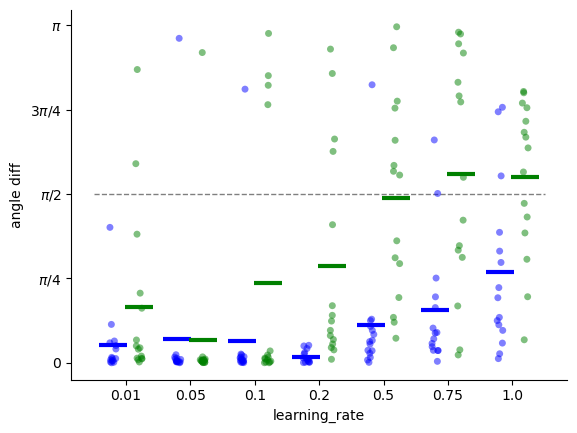

In [12]:
fig, ax = plt.subplots()
colors = ['blue', 'green']
sns.stripplot(data=offset_df, x='learning_rate', 
              y='angle diff', hue='rule', dodge=True, alpha=.5,
              ax=ax, legend=False,palette=colors,)
sns.pointplot(data=offset_df, x = 'learning_rate', y = 'angle diff',
              hue = 'rule', estimator=np.mean,
              linestyle='none', dodge=.4, errorbar=None,
              marker="_", markersize=20, markeredgewidth=3,
              ax=ax, legend=False, palette=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
              labels=['0', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])

ax.hlines(np.pi/2, -0.5, 6.5, color='black', linestyle='--', linewidth=1,
          alpha=.5, zorder=-1)
fig.savefig(figfolder / 'simulated_learning_rate_vs_angle_diff.pdf')

In [10]:

weights_dict = { 'fly_id':[],
                'learning_rate': [],
                'rule': [],
                'start_weights': [],
                'end_weights': [],}

for fly in ctrl_fly_ids:

    print(fly)
    for lr in learning_rates:
        with open(simdatadir / f"{fly}_results_learning_rate_{lr}.pkl", 'rb') as f:
            sim_data = pickle.load(f)

        for key in ['presynaptic', 'postsynaptic']:
            _sim_data = sim_data[key]
            if 'cl1' in _sim_data['start_end_times']:

                time = _sim_data['time'][1:]
                dark_times = _sim_data['start_end_times']['dark']
                

                weights = _sim_data['weights'][(time >= dark_times[0]) & (time <= dark_times[1]), :, :]

                weights_dict['fly_id'].append(fly)
                weights_dict['learning_rate'].append(lr)
                weights_dict['rule'].append(key)
                weights_dict['start_weights'].append(weights[0])
                weights_dict['end_weights'].append(weights[-1])

weights_df = pd.DataFrame(weights_dict)




06_01_2025_fly1_control
06_01_2025_fly2_control
07_01_2025_fly1_control
07_01_2025_fly2_control
09_01_2025_fly1_control
09_01_2025_fly3_control
09_01_2025_fly4_control
11_01_2025_fly3_control
17_01_2025_fly2_control
04_02_2025_fly5_control
04_02_2025_fly6_control
04_02_2025_fly2_control
05_02_2025_fly1_control
05_02_2025_fly2_control
05_02_2025_fly3_control
05_02_2025_fly5_control


In [11]:


for i, row in weights_df.iterrows():
    print(row['fly_id'], row['learning_rate'], row['rule'])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    h = ax[0].imshow(row['start_weights'], vmin=0, vmax=.33)
    plt.colorbar(h, ax=ax[0])
    ax[0].set_title('Start Weights')
    h = ax[1].imshow(row['end_weights'], vmin=0, vmax=.33)
    plt.colorbar(h, ax=ax[1])
    ax[1].set_title('End Weights')
    fig.suptitle(f"{row['fly_id']} - {row['learning_rate']} - {row['rule']}")

    tmp_figfolder = figfolder / 'simulation_figs' / row['fly_id']
    tmp_figfolder.mkdir(parents=True, exist_ok=True)
    fig.savefig(tmp_figfolder / f"{row['learning_rate']}_{row['rule']}_weights.pdf")
    plt.close(fig)
    

06_01_2025_fly1_control 0.01 presynaptic
06_01_2025_fly1_control 0.01 postsynaptic
06_01_2025_fly1_control 0.05 presynaptic
06_01_2025_fly1_control 0.05 postsynaptic
06_01_2025_fly1_control 0.1 presynaptic
06_01_2025_fly1_control 0.1 postsynaptic
06_01_2025_fly1_control 0.2 presynaptic
06_01_2025_fly1_control 0.2 postsynaptic
06_01_2025_fly1_control 0.5 presynaptic
06_01_2025_fly1_control 0.5 postsynaptic
06_01_2025_fly1_control 0.75 presynaptic
06_01_2025_fly1_control 0.75 postsynaptic
06_01_2025_fly1_control 1.0 presynaptic
06_01_2025_fly1_control 1.0 postsynaptic
06_01_2025_fly2_control 0.01 presynaptic
06_01_2025_fly2_control 0.01 postsynaptic
06_01_2025_fly2_control 0.05 presynaptic
06_01_2025_fly2_control 0.05 postsynaptic
06_01_2025_fly2_control 0.1 presynaptic
06_01_2025_fly2_control 0.1 postsynaptic
06_01_2025_fly2_control 0.2 presynaptic
06_01_2025_fly2_control 0.2 postsynaptic
06_01_2025_fly2_control 0.5 presynaptic
06_01_2025_fly2_control 0.5 postsynaptic
06_01_2025_fly2_co

(32, 233445) (233445,) (233445,) (233445,)
(32, 233445) (233445,) (233445,) (233445,)
(32, 282373) (282373,) (282373,) (282373,)
(32, 282373) (282373,) (282373,) (282373,)
(32, 221488) (221488,) (221488,) (221488,)
(32, 221488) (221488,) (221488,) (221488,)
(32, 240065) (240065,) (240065,) (240065,)
(32, 240065) (240065,) (240065,) (240065,)


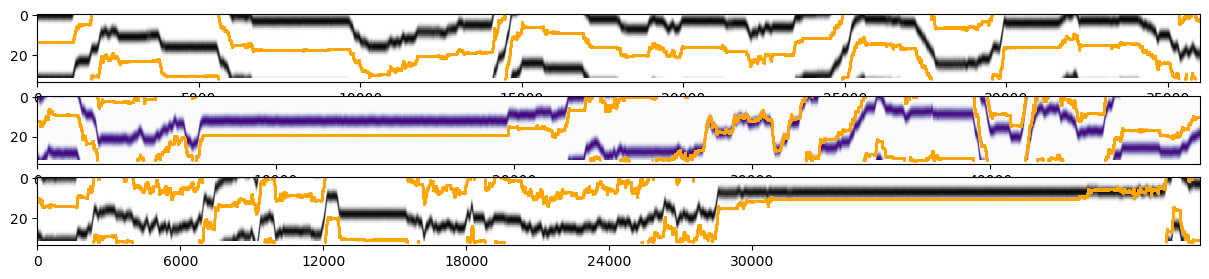

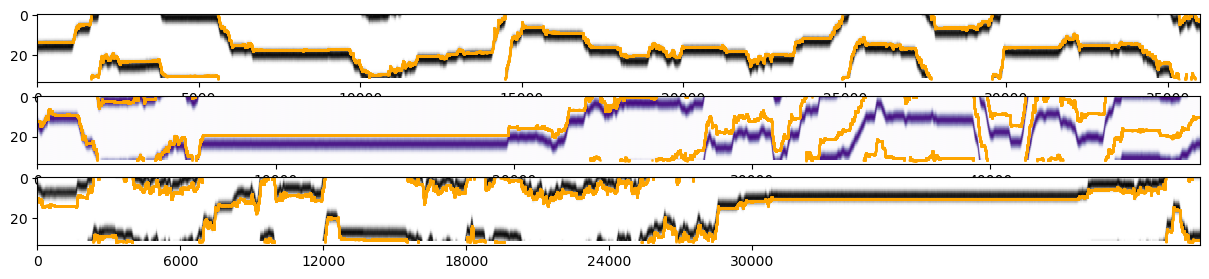

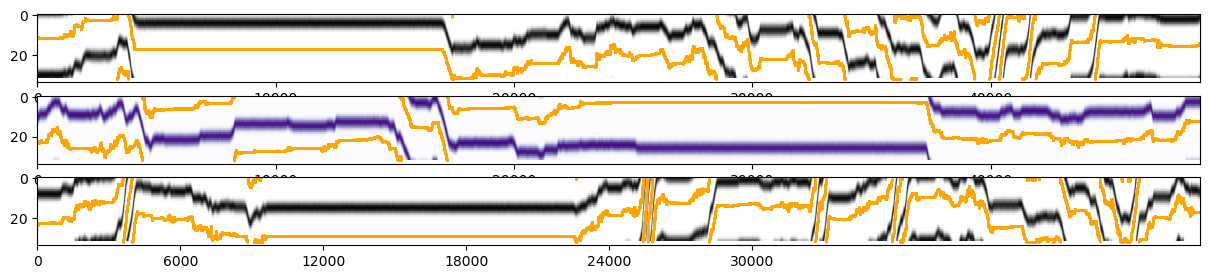

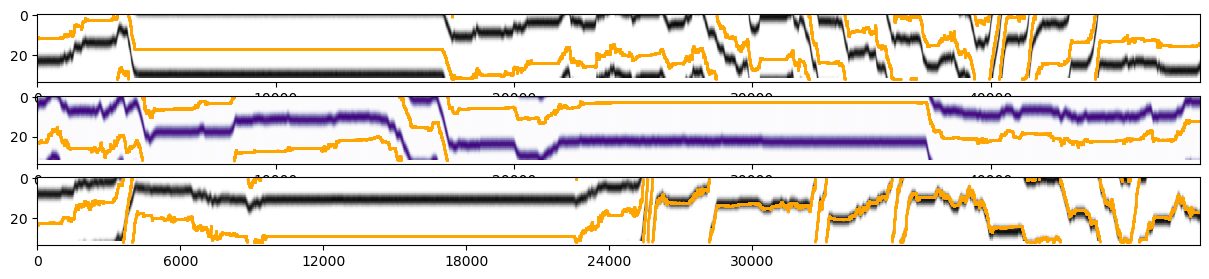

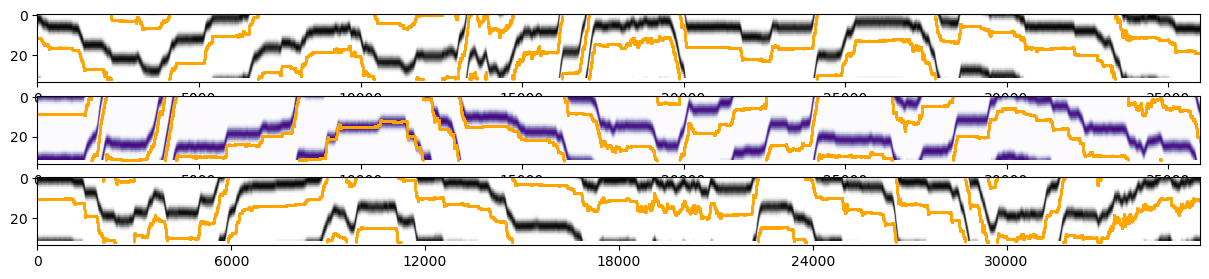

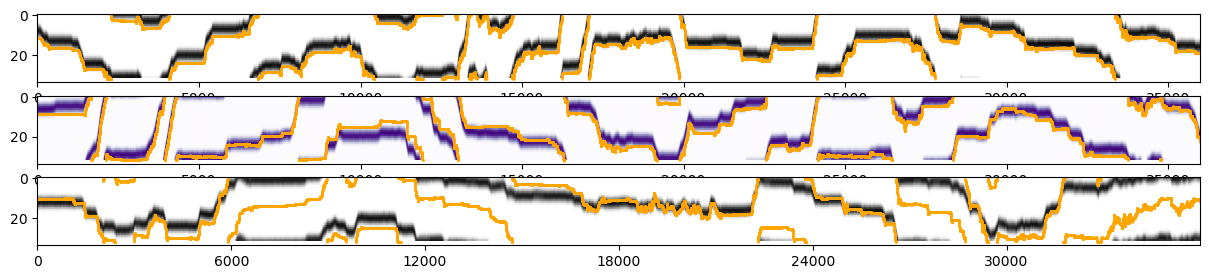

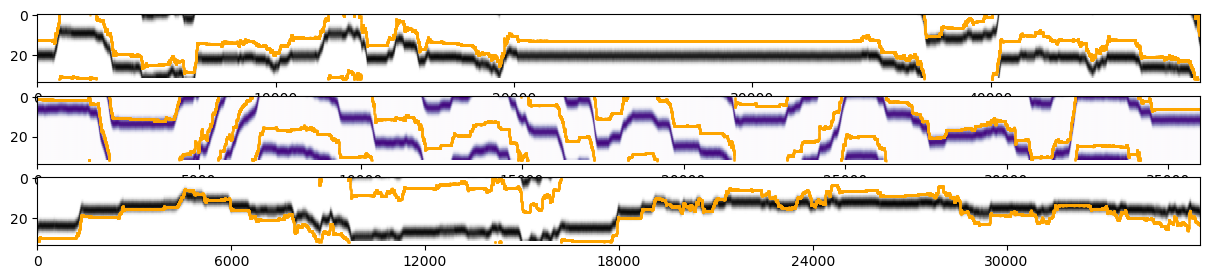

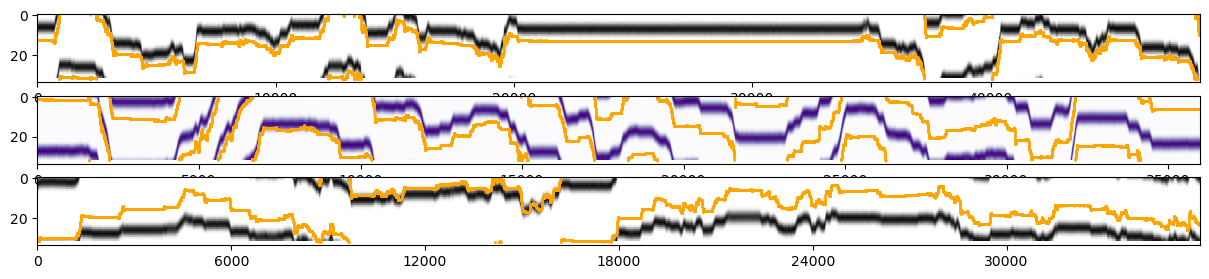

In [ ]:
# plot an example from moderate learning rate
def get_time_ticks_inds(time, plot_times=np.arange(0,360,60)):
        inds = []
        for t in plot_times:
            inds.append(np.argmin(np.abs(time-t)))
        return inds


lr = .75

for fly in ctrl_fly_ids[:4]:
    with open(simdatadir / f"{fly}_results_learning_rate_{lr}.pkl", 'rb') as f:
        sim_data = pickle.load(f)

    for key in ['presynaptic', 'postsynaptic']:
        _sim_data = sim_data[key]

        
        if 'cl1' in _sim_data['start_end_times']:
                cl1_times = _sim_data['start_end_times']['cl1']
                cl2_times = _sim_data['start_end_times']['cl2']
                dark_times = _sim_data['start_end_times']['dark']

                heading = _sim_data['heading'][1:]
                heading_ = (heading+np.pi)/2/np.pi*32
                time = _sim_data['time'][1:]
                offset = _sim_data['offset']
                dff = _sim_data['dff']
                print(dff.shape, time.shape, heading_.shape, offset.shape)

                fig, ax = plt.subplots(3, 1, figsize=(15,3), sharex=False, sharey=True)

                cl1_mask = (time >= cl1_times[0]) & (time <= cl1_times[1])
                cl2_mask = (time >= cl2_times[0]) & (time <= cl2_times[1])
                dark_mask = (time >= dark_times[0]) & (time <= dark_times[1])

                x = time[cl1_mask]
                x = np.arange(x.shape[0]) #x - x[0]
                ax[0].imshow(dff[:,cl1_mask], aspect='auto', cmap='Greys')
                ax[0].scatter(x, heading_[cl1_mask], c='orange', s=1, alpha=.5)
                x= time[dark_mask]
                x = np.arange(x.shape[0])
                ax[1].imshow(dff[:, dark_mask], aspect='auto', cmap='Purples')
                ax[1].scatter(x, heading_[dark_mask], c='orange', s=1, alpha=.5)
                ax[2].imshow(dff[:, cl2_mask], aspect='auto', cmap='Greys')
                x = time[cl2_mask]
                x = np.arange(x.shape[0])
                ax[2].scatter(x, heading_[cl2_mask], c='orange', s=1, alpha=.5)

                # set time for each sessin
                _t = time[cl2_mask]
                ax[2].set_xticks(get_time_ticks_inds(_t -_t[0]))

                # make histograme of offset and plot


                # set title

                # save

In [44]:
time[cl1_mask]

array([1083.07, 1083.08, 1083.09, ..., 1570.92, 1570.93, 1570.94])